In [4]:
%matplotlib widget
import argparse
import gc
import random
import torch
from PIL import Image
from torchvision.transforms import PILToTensor
import os
import torch
from PIL import Image
import torch
from tqdm import tqdm
from torchvision.transforms import PILToTensor
from llava.model.multimodal_encoder.diffLVLM.src.models.dift_sd import SDFeaturizer
from llava.model.multimodal_encoder.diffLVLM.src.models.dift_imsd import IMSDFeaturizer
from llava.model.multimodal_encoder.diffLVLM.src.models.dift_dit import DiTFeaturizer
from llava.model.multimodal_encoder.diffLVLM.src.models.dift_sd3 import SD3Featurizer
from llava.model.multimodal_encoder.clip_encoder import CLIPVisionTower
from llava.model.multimodal_encoder.dinov2_encoder import DinoV2VisionTower
from llava.model.multimodal_encoder.siglip_encoder import SigLipVisionTower

In [5]:
torch.cuda.set_device(2)

In [6]:
class args_c:
    def __init__(self):
        self.mm_vision_select_layer = -2

In [7]:
feature = "DINOv2"
if feature == "DIFT2.1":
    dift = SDFeaturizer(sd_id='stabilityai/stable-diffusion-2-1')
if feature == "DIFT1.5":
    dift = SDFeaturizer(sd_id='runwayml/stable-diffusion-v1-5')
elif feature == "DIFTXL":
    dift = SDFeaturizer(sd_id='stabilityai/stable-diffusion-xl-base-1.0')
elif feature == "IMDIFT":
    dift = IMSDFeaturizer()
elif feature == "DiTDIFT":
    dift = DiTFeaturizer()
elif feature == "SD3DIFT":
    dift = SD3Featurizer()
elif feature == "CLIP":
    args = args_c()
    dift = CLIPVisionTower(vision_tower='openai/clip-vit-large-patch14', args=args)
elif feature == "OPENCLIP":
    args = args_c()
    dift = CLIPVisionTower(vision_tower='laion/CLIP-ViT-L-14-laion2B-s32B-b82K', args=args)
elif feature == "DINOv2":
    args = args_c()
    dift = DinoV2VisionTower(vision_tower='facebook/dinov2-large', args=args)
elif feature == "SigLIP":
    args = args_c()
    dift = SigLipVisionTower(vision_tower='google/siglip-base-patch16-224', args=args).to(torch.bfloat16)

/home/tiger/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/tiger/.local/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
# you can choose visualize cat or guitar
# category = random.choice(['cat', 'guitar'])
category ='cat'

print(f"let's visualize semantic correspondence on {category}")

let's visualize semantic correspondence on cat


In [9]:
if category == 'cat':
    filelist = ['/opt/tiger/LLaVA1.5/llava/model/multimodal_encoder/diffLVLM/20240626-020227.jpeg', '/opt/tiger/LLaVA1.5/llava/model/multimodal_encoder/diffLVLM/20240626-175717.jpeg']
elif category == 'guitar':
    filelist = ['./assets/guitar.png', './assets/target_guitar.png']
elif category == '0':
    filelist = ['/viscam/projects/part_decomp/dift/eval_images/0/GCC_train_000261240.jpg', '/viscam/projects/part_decomp/dift/eval_images/0/GCC_train_002127756.jpg']
elif category == '1':
    filelist = ['/viscam/projects/part_decomp/dift/eval_images/1/GCC_train_000131600.jpg', '/viscam/projects/part_decomp/dift/eval_images/1/GCC_train_000156948.jpg']
elif category == '2':
    filelist = ['/viscam/projects/part_decomp/dift/eval_images/2/GCC_train_000691494.jpg', '/viscam/projects/part_decomp/dift/eval_images/2/GCC_train_002280061.jpg']
elif category == '3':
    filelist = ['/viscam/projects/part_decomp/dift/eval_images/3/GCC_train_000235136.jpg', '/viscam/projects/part_decomp/dift/eval_images/3/GCC_train_002290062.jpg']
elif category == '4':
    filelist == ['/viscam/projects/part_decomp/dift/eval_images/4/GCC_train_000221071.jpg', '/viscam/projects/part_decomp/dift/eval_images/4/GCC_train_000324898.jpg']
elif category == '5':
    filelist = ['/viscam/projects/part_decomp/dift/eval_images/5/GCC_train_002329580.jpg', '/viscam/projects/part_decomp/dift/eval_images/5/GCC_train_002514353.jpg']
elif category == '6':
    filelist = ['/viscam/projects/part_decomp/dift/eval_images/6/GCC_train_002501270.jpg', '/viscam/projects/part_decomp/dift/eval_images/6/GCC_train_002534171.jpg']
elif category == '7':
    filelist = ['/viscam/projects/part_decomp/dift/eval_images/7/GCC_train_001915506.jpg', '/viscam/projects/part_decomp/dift/eval_images/7/GCC_train_002538120.jpg']
elif category == '8':
    filelist = ['/viscam/projects/part_decomp/dift/eval_images/8/GCC_train_001163466.jpg', '/viscam/projects/part_decomp/dift/eval_images/8/GCC_train_001164170.jpg']
elif category == '9':
    filelist = ['/viscam/projects/part_decomp/dift/eval_images/9/GCC_train_000141221.jpg', '/viscam/projects/part_decomp/dift/eval_images/9/GCC_train_002462785.jpg']



# prompt = f'a photo of a {category}'
prompt = ''

In [13]:
prompt = ''
ensemble_size = 1

ft = []
imglist = []

# decrease these two if you don't have enough RAM or GPU memory
if feature == "DIFT":
    img_size = 768
elif feature == "IMDIFT":
    img_size = 768
elif feature == "CLIP":
    img_size = 224
elif feature == "DiTDIFT":
    img_size = 512
elif feature == "DINOv2":
    img_size = 518
elif feature == 'SD3DIFT':
    img_size = 512
ensemble_size = 1

for filename in filelist:
    img = Image.open(filename).convert('RGB')
    img = img.resize((img_size, img_size))
    imglist.append(img)
    img_tensor = (PILToTensor()(img) / 255.0 - 0.5) * 2
    if feature == "DIFT":
        ft.append(dift.forward(img_tensor,
                            prompt=prompt,
                            ensemble_size=ensemble_size))
    elif feature == "IMDIFT":
        f = dift.forward(img_tensor=img_tensor.unsqueeze(0),
                            prompt=prompt,
                            ensemble_size=ensemble_size)
        print(f.unsqueeze(0).shape)
        ft.append(f.unsqueeze(0))
    elif feature == "CLIP":
        f = dift.forward(img_tensor.unsqueeze(0))
        print(f.shape)

    elif feature == "DINOv2":
        f = dift.forward(img_tensor.unsqueeze(0))
        print(f.shape)
        # (1, 256, 1024)
        # f = f[:, 1:, :]
        ft.append(f.permute(0,2,1).view(1, 1024, 37, 37))
    elif feature == "DiTDIFT":
        f = dift.forward(img_tensor.unsqueeze(0).to(torch.bfloat16),
                        prompt=prompt,
                        ensemble_size=ensemble_size)
        print(f.shape)
        # (1, 256, 1024)
        ft.append(f)
    elif feature == "SD3DIFT":
        f = dift.forward(img_tensor.unsqueeze(0).to(torch.bfloat16),
                        prompt=prompt,
                        ensemble_size=ensemble_size,up_ft_index=1).to(torch.float32)
        print(f.shape)
        # (1, 256, 1024)
        ft.append(f)

ft = torch.cat(ft, dim=0)
print(ft.shape)
gc.collect()
torch.cuda.empty_cache()

torch.Size([1, 1369, 1024])
torch.Size([1, 1369, 1024])
torch.Size([2, 1024, 37, 37])


In [14]:
demo = Demo(imglist, ft, img_size)

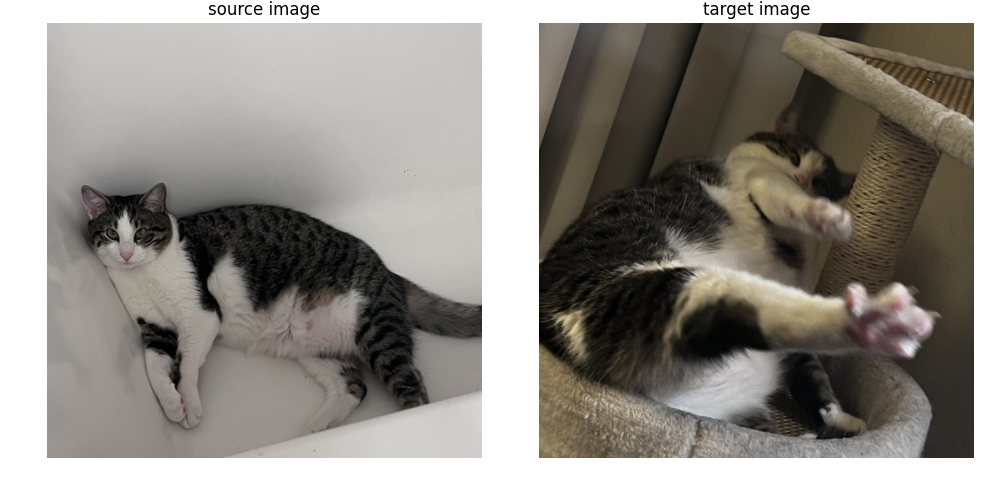

In [15]:
'''
left is source image, right is target image.
you can click on the source image, and DIFT will find the corresponding
point on the right image, mark it with red point and also plot the per-pixel 
cosine distance as heatmap.
'''
demo.plot_img_pairs(fig_size=5)